In [555]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, SimpleRNN, Reshape, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb


import seaborn as sns


In [515]:
df1 = pd.read_csv("./dataset/backloggd_games.csv")
df2 = pd.read_csv("./dataset/video_games_sales.csv") 
df3 = pd.read_csv("./dataset/video_game_reviews.csv")


merged_df = pd.merge(df1,df2, left_on="Title", right_on="name", how="inner")
df = pd.merge(merged_df, df3, left_on="Title", right_on="Game Title", how="inner")

df.shape

(81729, 43)

In [545]:


df = df.drop(columns=[
    "Unnamed: 0",
    "platform",
    "name",
    "Summary",
    "rank",
    "na_sales",
    "Game Title",
    "eu_sales",
    "Min Number of Players",
    "jp_sales",
    "other_sales",
    "Title",
    "Release_Date",
    "Developers",
    "Release Year",
    "Publisher"
])


df.sample(10)

KeyError: "['Unnamed: 0', 'platform', 'name', 'Summary', 'rank', 'na_sales', 'Game Title', 'eu_sales', 'Min Number of Players', 'jp_sales', 'other_sales', 'Title', 'Release_Date', 'Developers', 'Release Year', 'Publisher'] not found in axis"

In [517]:
df.isnull().sum()

df["Rating"] = df["Rating"].fillna(df["Rating"].median())

df["year"] = df["year"].fillna(df["year"].median())

df["publisher"] = df["publisher"].fillna("Unknown")

df.isnull().sum()

Platforms                  0
Genres                     0
Rating                     0
Plays                      0
Playing                    0
Backlogs                   0
Wishlist                   0
Lists                      0
Reviews                    0
year                       0
genre                      0
publisher                  0
global_sales               0
User Rating                0
Age Group Targeted         0
Price                      0
Platform                   0
Requires Special Device    0
Developer                  0
Multiplayer                0
Game Length (Hours)        0
Graphics Quality           0
Soundtrack Quality         0
Story Quality              0
User Review Text           0
Game Mode                  0
dtype: int64

In [518]:
num_cols = ["Plays", "Playing", "Backlogs", "Wishlist", "Lists",]

for col in num_cols:
    df[col] = df[col].str.replace(",", "")  
    df[col] = pd.to_numeric(df[col], errors='coerce') 
    
df[num_cols] = df[num_cols].fillna(0)


In [519]:

high_card_cols = ["Developer", "publisher", "Genres", "Platforms", "Age Group Targeted"]
le = LabelEncoder()

for col in high_card_cols:
    df[col] = le.fit_transform(df[col])


In [520]:
binary_cols = ['Requires Special Device','Multiplayer', 'Graphics Quality', 'Soundtrack Quality','Story Quality','Game Mode']

df = pd.get_dummies(df, columns=binary_cols, drop_first=True)

In [521]:
df.info()
df.sample(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81729 entries, 0 to 81728
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platforms                     81729 non-null  int32  
 1   Genres                        81729 non-null  int32  
 2   Rating                        81729 non-null  float64
 3   Plays                         81729 non-null  float64
 4   Playing                       81729 non-null  float64
 5   Backlogs                      81729 non-null  float64
 6   Wishlist                      81729 non-null  float64
 7   Lists                         81729 non-null  float64
 8   Reviews                       81729 non-null  object 
 9   year                          81729 non-null  float64
 10  genre                         81729 non-null  object 
 11  publisher                     81729 non-null  int32  
 12  global_sales                  81729 non-null  float64
 13  U

,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews,year,...,Graphics Quality_Low,Graphics Quality_Medium,Graphics Quality_Ultra,Soundtrack Quality_Excellent,Soundtrack Quality_Good,Soundtrack Quality_Poor,Story Quality_Excellent,Story Quality_Good,Story Quality_Poor,Game Mode_Online
38030,13,10,3.8,0.0,42.0,767.0,332.0,0.0,531,2009.0,...,False,False,False,True,False,False,False,True,False,True
72441,6,8,3.9,2.0,0.0,0.0,0.0,2.0,0,1989.0,...,False,False,True,False,False,False,True,False,False,True
35856,13,10,3.8,0.0,42.0,767.0,332.0,0.0,531,2009.0,...,False,False,True,True,False,False,True,False,False,True
24156,16,1,3.8,0.0,689.0,0.0,0.0,0.0,1.2K,2011.0,...,True,False,False,False,False,True,False,False,True,True
51066,1,5,3.9,38.0,0.0,2.0,2.0,11.0,2,1989.0,...,False,False,False,True,False,False,False,True,False,True
17927,14,1,4.3,0.0,0.0,0.0,0.0,0.0,944,2015.0,...,False,True,False,True,False,False,False,False,False,True
68356,3,5,4.2,89.0,1.0,17.0,11.0,42.0,6,1988.0,...,False,False,False,False,True,False,False,False,False,True
59360,7,8,4.3,19.0,0.0,2.0,2.0,7.0,0,1988.0,...,False,False,True,True,False,False,False,False,True,False
11918,17,2,3.8,0.0,958.0,0.0,757.0,0.0,1.7K,2013.0,...,False,False,True,False,False,True,False,False,True,False
35685,13,10,3.8,0.0,42.0,767.0,332.0,0.0,531,2009.0,...,True,False,False,False,False,False,False,False,False,True


In [522]:
sentiment_df = pd.read_csv("./dataset/output.csv")

sentiment_df['is_positive'] = sentiment_df['is_positive'].map({'Positive':1, 'Negative':0})

sentiment_df.sample(10)

,id,app_id,content,author_id,is_positive
54918,178295499,730,ridden with cheaters id rather use wooden shav...,76561198313251153,0
40308,155496344,570,Хуйня ебаная,76561199157030221,0
186913,167452328,730,ITS KIND OF GARBAGE,76561199046980441,0
138696,10397629,340,short episode for TRUE HL fans.\n8/10,76561198025256560,1
93791,6051825,630,EPIC,76561198058019280,1
20913,124874372,70,**STEAM DECK APPROVED**\n\nFirst let me tell y...,76561198130387049,0
146280,178558691,550,"Nothing to say, this game just TOO GOOD!",76561198028326357,1
114009,146226435,300,displace,76561198299742471,1
40158,155916308,570,No,76561198114788550,0
83053,72201348,130,In this Expansion you play As the Blue guard h...,76561198210342215,1


In [523]:
reviews = sentiment_df['content'].astype(str)
y = sentiment_df['is_positive'].values

In [524]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews)

X_seq = tokenizer.texts_to_sequences(reviews)
X_pad = pad_sequences(X_seq, maxlen=max_len)


In [525]:
X_train, X_val, y_train, y_val = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)


In [526]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\abdel\Desktop\Senior Year\AI\venv2\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [527]:
history = model.fit(
    X_train, y_train,
    epochs=10,          
    batch_size=128,
    validation_data=(X_val, y_val)
)


Epoch 1/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.8164 - loss: 0.3941 - val_accuracy: 0.8386 - val_loss: 0.3433
Epoch 2/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8559 - loss: 0.3251 - val_accuracy: 0.8501 - val_loss: 0.3317
Epoch 3/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8659 - loss: 0.3047 - val_accuracy: 0.8519 - val_loss: 0.3304
Epoch 4/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8724 - loss: 0.2899 - val_accuracy: 0.8544 - val_loss: 0.3300
Epoch 5/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8792 - loss: 0.2774 - val_accuracy: 0.8514 - val_loss: 0.3353
Epoch 6/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.8841 - loss: 0.2665 - val_accuracy: 0.8548 - val_loss: 0.3427
Epoch 7/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8884 - loss: 0.2568 - val_accuracy: 0.8542 - val_loss: 0.3404
Epoch 8/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.8929 -

In [ ]:
main_reviews = df['User Review Text'].astype(str)

main_seq = tokenizer.texts_to_sequences(main_reviews)
main_pad = pad_sequences(main_seq, maxlen=max_len)

batch_size = 512
preds = model.predict(main_pad, batch_size=batch_size)
review_sentiment = (preds > 0.5).astype(int)

df['review_sentiment'] = review_sentiment


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews,year,...,Graphics Quality_Medium,Graphics Quality_Ultra,Soundtrack Quality_Excellent,Soundtrack Quality_Good,Soundtrack Quality_Poor,Story Quality_Excellent,Story Quality_Good,Story Quality_Poor,Game Mode_Online,review_sentiment
0,10,3,4.3,0.0,0.0,0.0,265.0,0.0,2700.0,2013.0,...,False,False,False,True,False,False,False,False,False,1
1,10,3,4.3,0.0,0.0,0.0,265.0,0.0,2700.0,2013.0,...,False,False,True,False,False,False,False,False,True,1
2,10,3,4.3,0.0,0.0,0.0,265.0,0.0,2700.0,2013.0,...,False,False,False,False,False,True,False,False,True,1
3,10,3,4.3,0.0,0.0,0.0,265.0,0.0,2700.0,2013.0,...,False,False,False,True,False,True,False,False,False,1
4,10,3,4.3,0.0,0.0,0.0,265.0,0.0,2700.0,2013.0,...,False,False,False,False,True,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81724,4,8,3.7,77.0,0.0,11.0,7.0,18.0,5.0,1988.0,...,False,False,False,False,True,False,True,False,True,1
81725,4,8,3.7,77.0,0.0,11.0,7.0,18.0,5.0,1988.0,...,True,False,False,False,False,False,False,True,True,1
81726,4,8,3.7,77.0,0.0,11.0,7.0,18.0,5.0,1988.0,...,False,False,False,True,False,False,False,False,True,1
81727,4,8,3.7,77.0,0.0,11.0,7.0,18.0,5.0,1988.0,...,False,True,True,False,False,True,False,False,False,1


In [553]:

X = df.drop(columns=['global_sales'])
y = df['global_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81729 entries, 0 to 81728
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platforms                     81729 non-null  int32  
 1   Genres                        81729 non-null  int32  
 2   Rating                        81729 non-null  float64
 3   Plays                         81729 non-null  float64
 4   Playing                       81729 non-null  float64
 5   Backlogs                      81729 non-null  float64
 6   Wishlist                      81729 non-null  float64
 7   Lists                         81729 non-null  float64
 8   Reviews                       81729 non-null  float64
 9   year                          81729 non-null  float64
 10  publisher                     81729 non-null  int32  
 11  User Rating                   81729 non-null  float64
 12  Age Group Targeted            81729 non-null  int32  
 13  P

In [554]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest R^2:", r2)
print("Random Forest RMSE:", rmse)

Random Forest R^2: 0.9763173526578953
Random Forest RMSE: 1.762475102970148


In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost R^2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

[0]	validation_0-rmse:10.89062
[10]	validation_0-rmse:7.82604
[20]	validation_0-rmse:5.59922
[30]	validation_0-rmse:3.98155
[40]	validation_0-rmse:2.86430
[50]	validation_0-rmse:2.33338
[60]	validation_0-rmse:1.87514
[70]	validation_0-rmse:1.69102
[80]	validation_0-rmse:1.61912
[90]	validation_0-rmse:1.59231
[100]	validation_0-rmse:1.57816
[110]	validation_0-rmse:1.57708
[120]	validation_0-rmse:1.58145
[130]	validation_0-rmse:1.58762
[140]	validation_0-rmse:1.59890
[150]	validation_0-rmse:1.61045
[160]	validation_0-rmse:1.62381
[170]	validation_0-rmse:1.64321
[180]	validation_0-rmse:1.66351
[190]	validation_0-rmse:1.68492
[200]	validation_0-rmse:1.70516
[210]	validation_0-rmse:1.72790
[220]	validation_0-rmse:1.74258
[230]	validation_0-rmse:1.75895
[240]	validation_0-rmse:1.77459
[250]	validation_0-rmse:1.78955
[260]	validation_0-rmse:1.80583
[270]	validation_0-rmse:1.81911
[280]	validation_0-rmse:1.83181
[290]	validation_0-rmse:1.84711
[300]	validation_0-rmse:1.86075
[310]	validation_0

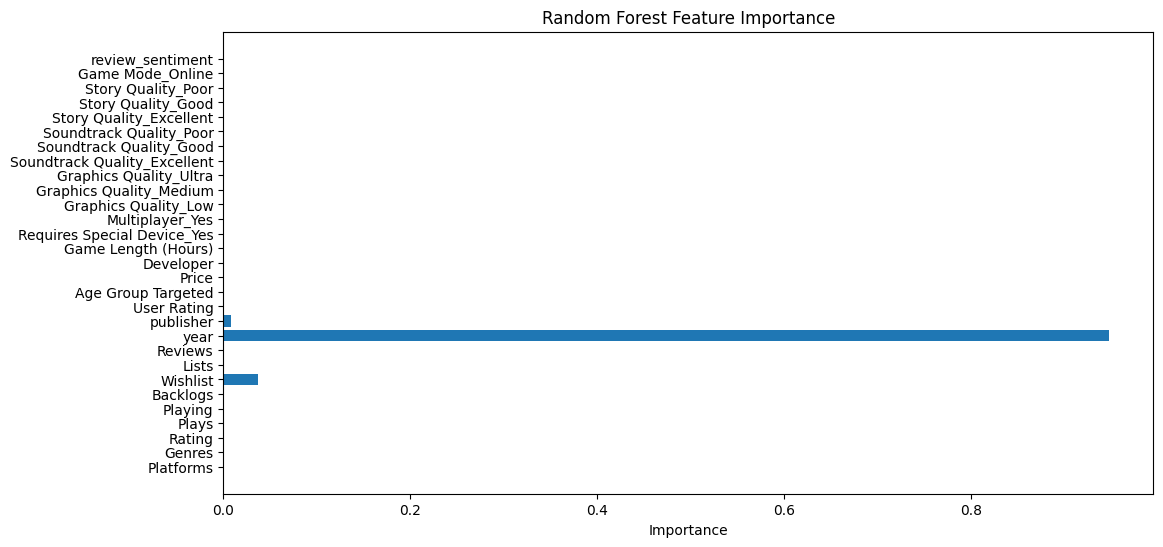

In [560]:
importances_rf = rf_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(12,6))
plt.barh(feat_names, importances_rf)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()


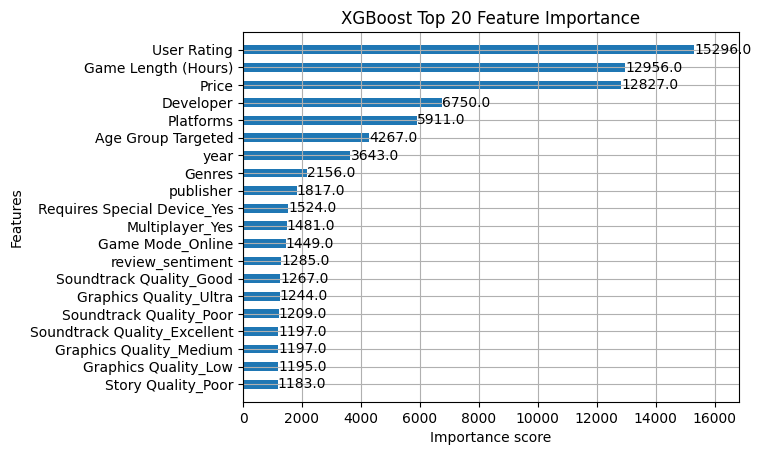

In [559]:
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='weight', height=0.5)
plt.title("XGBoost Top 20 Feature Importance")
plt.show()
